## Capstone project Pricify

#### Business Understanding

The goal is to build a model to predict a price for item by picture. As OfferUp says that "With a single snap, you can take a photo of an item and instantly circulate it to people nearby.", it sounds interesting to suggest the price, so you can take a photo of item and decide either you should sell it or not.

### Data Understanding

OfferUp scraping

scrap_offerup.rb  - HTTP Request to https://offerupnow.com/ and scrap the recent offers page by page until the date limit was reached. Each offer was stored into file in JSON format. 

normalize_scraped.rb - Spliting and combining offers into 3 JSON files, I got:
offerup-data
* items.json 605 Mb ? items
* owners.json 141.2 Mb ? item owners
* images.json 214.1 Mb ? links to item images

offerup-images - 3 size of images organizes into subfolders with offer-id name.
* detail
* full
* list



Где скрип для картинок?!

TODO: Add scrip run command

In [1]:
import pandas as pd
import matplotlib
%matplotlib inline

In [2]:
df = pd.read_json('../data/items.json')

In [3]:
cdf = df.copy()

In [4]:
df.shape

(380107, 34)

In [5]:
df.head()

,category,condition,description,distance,get_full_url,get_img_medium_height,get_img_medium_width,get_img_permalink_large,get_img_permalink_medium,get_img_permalink_small,...,post_from_store_address,price,priority,reservable,reserved,review_status,sold_date,sold_offer_id,state,title
0,"{u'id': 2, u'name': u'Household'}",40,Colorful mosaic that brightens up a room! 1.5'...,15,https://offerupnow.com/item/detail/96366652/fl...,400,300,https://d2j6tswx2otu6e.cloudfront.net/V_DoSoMA...,https://d2j6tswx2otu6e.cloudfront.net/8toAz7Tj...,https://d2j6tswx2otu6e.cloudfront.net/KPORxbgy...,...,"Lynnwood, WA",10,100,False,False,2,None,NaN,3,Fleur d' lys mosaic artwork
1,"{u'id': 13, u'name': u'Beauty & Health'}",100,2 NYX Avant Pop Palettes. Has 10 different eye...,15,https://offerupnow.com/item/detail/96366557/ny...,400,300,https://d2j6tswx2otu6e.cloudfront.net/lv6RLzOC...,https://d2j6tswx2otu6e.cloudfront.net/z0pDlQul...,https://d2j6tswx2otu6e.cloudfront.net/OujFPQXl...,...,"Lynnwood, WA",25,100,False,False,2,None,NaN,3,NYX Avant Pop Palettes
2,"{u'id': 3, u'name': u'General'}",40,Size 28 only put on once very nice jeans,18,https://offerupnow.com/item/detail/96366541/mi...,225,300,https://d2j6tswx2otu6e.cloudfront.net/gY13xLL9...,https://d2j6tswx2otu6e.cloudfront.net/-5KLMMcI...,https://d2j6tswx2otu6e.cloudfront.net/Zqk9QmT3...,...,"Lynnwood, WA",60,100,False,False,2,None,NaN,3,Miss Me jeans
3,"{u'id': 3, u'name': u'General'}",40,Red justice jean shorts,4,https://offerupnow.com/item/detail/96366520/re...,400,300,https://d2j6tswx2otu6e.cloudfront.net/e7zVb3QB...,https://d2j6tswx2otu6e.cloudfront.net/_Sm3yKZR...,https://d2j6tswx2otu6e.cloudfront.net/ge9ot77Y...,...,"Lake Stevens, WA",3,100,False,False,2,None,NaN,3,red Justice jeans shorts
4,"{u'id': 1, u'name': u'Electronics'}",40,Great condition,26,https://offerupnow.com/item/detail/96366471/su...,400,300,https://d2j6tswx2otu6e.cloudfront.net/OqwfY7Q7...,https://d2j6tswx2otu6e.cloudfront.net/v0gyLUF5...,https://d2j6tswx2otu6e.cloudfront.net/UaGTB7eA...,...,"Seattle, WA",400,100,False,False,2,None,NaN,3,Surface pro 3 128gb


In [6]:
sample = df.sample(100)

In [7]:
sample.shape

(100, 34)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 380107 entries, 0 to 380106
Data columns (total 34 columns):
category                      380107 non-null object
condition                     380107 non-null int64
description                   380107 non-null object
distance                      380107 non-null int64
get_full_url                  380107 non-null object
get_img_medium_height         380107 non-null int64
get_img_medium_width          380107 non-null int64
get_img_permalink_large       380107 non-null object
get_img_permalink_medium      380107 non-null object
get_img_permalink_small       380107 non-null object
get_img_small_height          380107 non-null int64
get_img_small_width           380107 non-null int64
get_small_square_thumbanil    380107 non-null object
id                            380107 non-null int64
image                         159857 non-null object
image_mob_det_hd              380107 non-null object
image_mob_list_hd             380107 non-null ob

### Data Preparation

Start from item.json. We got 380,107 rows and 34 columns. 

Columns are: 

* category - object (calculate how many categories, split into separate table?)
* condition	 - int (40, 100 ? looks like categorical)
* description - text
* distance	- distance from logged user, not applicable
* get_full_url	- link to offer
* get_img_medium_height	400
* get_img_medium_width	300
* get_img_permalink_large
* get_img_permalink_medium
* get_img_permalink_small
* get_img_small_height
* get_img_small_width
* get_small_square_thumbanil
* id	65194613
* image	None
* image_mob_det_hd
* image_mob_list_hd
* latitude	47.8426
* listing_type	2
* location_name	Lynnwood, WA
* longitude	-122.295
* owner_id	6787474
* payable	False
* post_date	2015-12-19T19:38:50.398Z
* post_from_store_address	Lynnwood, WA
* price	25
* priority	100
* reservable	False
* reserved	False
* review_status	2
* sold_date	None
* sold_offer_id	NaN
* state	3
* title

1. Category
 - category 380107 non-null object - no missing values
 - Create two features with category data - category_id and category_name

In [9]:
cdf['category_id'] =  cdf.category.apply(lambda x: int(x['id']))

In [10]:
cdf['category_name'] =  cdf.category.apply(lambda x: str(x['name']))

In [73]:
cat_counts = cdf['category_name'].value_counts()

In [76]:
len(cat_counts)

37

In [93]:
cat_counts

Baby & Kids              46130
Clothing & Shoes         33174
Furniture                30387
Jewelry & Accessories    29923
General                  28770
Household                27960
Cell Phones              19568
Electronics              18968
Collectibles             14783
Sports & Outdoors        13881
Home & Garden            12230
Cars & Trucks            11199
Auto Parts               10711
Games & Toys             10312
Beauty & Health           8298
Tools & Machinery         8198
Arts & Crafts             6933
Antiques                  5860
Appliances                5716
Computer Equipment        4772
Audio Equipment           4673
Video Games               4000
Bicycles                  3551
Motorcycles               3278
Pet Supplies              2987
Musical Instruments       2741
Photography               1978
TVs                       1863
Boats & Marine            1490
Business Equipment        1431
CDs & DVDs                1219
Farming                    620
Campers 

So, we have 37 categories of items

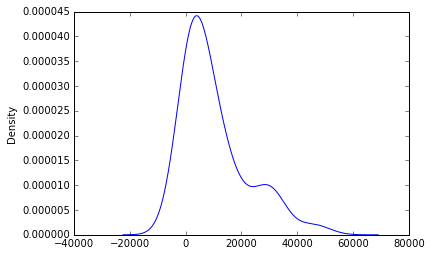

In [92]:
cat_counts.plot(kind='density')

1. Condition
- condition 380107 non-null int64 - no missing values
- value range: [0, 20, 40, 60, 80, 100], so it looks like categorical.
- Create 6 features with conditions

In [101]:
condition_counts = cdf['condition'].value_counts()

In [102]:
condition_counts

40     268919
100     71506
60      24276
80       9918
0        4423
20       1065
Name: condition, dtype: int64

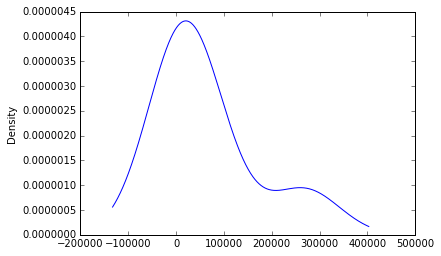

In [113]:
condition_counts.plot(kind='density')

In [112]:
for i in  [0, 20, 40, 60, 80, 100]:
    cdf['condition_' + str(i)] =  cdf.condition.apply(lambda x: 1 if x == i else 0 )